In [1]:
import os
import cv2
import keras
import shutil
import random
import gc
import numpy as np
import pandas as pd 
import tensorflow as tf
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Average, Dense ,Layer
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization,MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.layers import Concatenate
from kerastuner.tuners import RandomSearch
from keras.models import load_model
from tensorflow.keras.applications import Xception,EfficientNetB0
from tensorflow.keras.utils import Sequence
from tensorflow.keras import mixed_precision , applications,layers
from keras.applications.resnet50 import preprocess_input
mixed_precision.set_global_policy('mixed_float16')

2024-06-09 16:17:08.019978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 16:17:08.020072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 16:17:08.136329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_25/3400929819.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
image_shape = (224, 224, 3)
num_classes = 5  
num_views = 7
batch_size = 32

In [3]:
'''# Source path of the model
source_path = "/kaggle/input/bone-type-midway-multi/keras/xception-trails/1/xceptionattentionregularizedno-hypertuning.keras"

# Destination path where you can write
destination_path = "/kaggle/working/model.keras"

# Copy the model file
shutil.copyfile(source_path, destination_path)

# Now load the model from the copied file
model = load_model(destination_path)'''

'# Source path of the model\nsource_path = "/kaggle/input/bone-type-midway-multi/keras/xception-trails/1/xceptionattentionregularizedno-hypertuning.keras"\n\n# Destination path where you can write\ndestination_path = "/kaggle/working/model.keras"\n\n# Copy the model file\nshutil.copyfile(source_path, destination_path)\n\n# Now load the model from the copied file\nmodel = load_model(destination_path)'

In [4]:
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, image_shape, num_classes, num_views=num_views):
        super().__init__()
        self.image_paths = list(image_paths)
        self.labels = list(labels)
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.num_classes = num_classes
        self.num_views = num_views
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in indices]
        batch_labels = [self.labels[i] for i in indices]

        images = []
        for folder_path in batch_image_paths:
            images.append(self._load_and_pad_images(folder_path, self.image_shape))

        images = np.array(images)  # Shape: (batch_size, num_views, height, width, channels)
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)

        # Transpose the batch to separate views as different inputs
        images = [images[:, i, :, :, :] for i in range(self.num_views)]
        
        # Convert to tuple of tensors
        images = tuple(tf.convert_to_tensor(img) for img in images)
        batch_labels = tf.convert_to_tensor(batch_labels)

        return images, batch_labels

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        np.random.shuffle(self.indices)

    def _load_and_pad_images(self, folder_path, image_shape):
        image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                       if f.endswith((".jpg", ".jpeg", ".png")) and not f.startswith("._")]

        if not image_paths:
            logger.error(f"No valid images found in folder: {folder_path}")
            return [np.zeros((image_shape[0], image_shape[1], image_shape[2]))] * self.num_views

        if len(image_paths) > self.num_views:
            image_paths = random.sample(image_paths, self.num_views)

        processed_images = []
        for image_path in image_paths:
            try:
                img = load_img(image_path, target_size=image_shape)
                img_array = img_to_array(img)
                img_array = img_array / 255.0
                preprocessed_img_array = preprocess_input(img_array)
                processed_images.append(preprocessed_img_array)
            except Exception as e:
                logger.warning(f"Warning: Skipping unidentifiable image file: {image_path} due to {e}")
                processed_images.append(np.zeros((image_shape[0], image_shape[1], image_shape[2])))

        while len(processed_images) < self.num_views:
            processed_images.append(np.zeros((image_shape[0], image_shape[1], image_shape[2])))

        return np.array(processed_images)


In [5]:
bone_type_mapping = {'SHOULDER': 0, 'WRIST': 1, 'HAND': 2, 'ELBOW': 3, 'FINGER': 4}
prefix = '/kaggle/input/mura-v11/'
output_directory = '/kaggle/working'
train_excel_file_path = '/kaggle/input/csv-for-multiview/Patients with bone type for multiview.csv'
df = pd.read_csv(train_excel_file_path, header=None,names=['Path', 'Abnormal','Bone_type'])
df = df[~df['Path'].str.contains('XR_FOREARM|XR_HUMERUS')]
df['Bone_type'] = df['Bone_type'].map(bone_type_mapping).astype(int)
paths = prefix + df['Path'].astype(str)
labels = df['Bone_type']
labels = labels.astype(str)
t_images = pd.concat([paths, labels], axis=1)
train_df, test_df = train_test_split(t_images, train_size=0.8, shuffle=True, random_state=1)
print(train_df)
print("===============Done with training images===================")
test_excel_file_path = '/kaggle/input/csv-for-multiview/validation Patients with bone type for multiview.csv'
df = pd.read_csv(test_excel_file_path, header=None,names=['Path', 'Abnormal','Bone_type'])
df = df[~df['Path'].str.contains('XR_FOREARM|XR_HUMERUS')]
df['Bone_type'] = df['Bone_type'].map(bone_type_mapping).astype(int)
paths = prefix + df['Path'].astype(str)
labels = df['Bone_type']
labels = labels.astype(str)
v_images = pd.concat([paths, labels], axis=1)
print("===============Done with test images===================")

                                                    Path Bone_type
9666   /kaggle/input/mura-v11/MURA-v1.1/train/XR_WRIS...         1
9719   /kaggle/input/mura-v11/MURA-v1.1/train/XR_WRIS...         1
5328   /kaggle/input/mura-v11/MURA-v1.1/train/XR_FING...         4
2159   /kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...         0
4740   /kaggle/input/mura-v11/MURA-v1.1/train/XR_FING...         4
...                                                  ...       ...
8405   /kaggle/input/mura-v11/MURA-v1.1/train/XR_WRIS...         1
12424  /kaggle/input/mura-v11/MURA-v1.1/train/XR_HAND...         2
905    /kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...         0
5784   /kaggle/input/mura-v11/MURA-v1.1/train/XR_ELBO...         3
235    /kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...         0

[9590 rows x 2 columns]
===============Done with training images===================
===============Done with test images===================


In [6]:
#Data Generators Initialization 
train_paths,train_labels = train_df['Path'] , train_df['Bone_type']
valid_paths,valid_labels = test_df['Path'] , test_df['Bone_type']
test_paths,test_labels = v_images['Path'] , v_images['Bone_type']

train_generator = CustomDataGenerator(train_paths, train_labels, batch_size, image_shape, num_classes)
valid_generator = CustomDataGenerator(valid_paths, valid_labels, batch_size, image_shape, num_classes)
test_generator = CustomDataGenerator(test_paths, test_labels, batch_size, image_shape, num_classes)

In [7]:
#Callbacks Initialization
checkpoint_path = '/kaggle/working/multiple_view_shoulder_v2.keras'
Monitored_metric= 'val_loss' 
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor=Monitored_metric,  # The metric to monitor for early stopping
                               patience=10,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,  # Verbosity level
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric

# Create a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor=Monitored_metric,  # The metric to monitor for saving the best model
                                   save_best_only=True,  # Save only the best model
                                   mode='min',  # Mode for the 'monitor' metric (e.g., 'min' for loss)
                                   verbose=1)  # Verbosity level
learn_control = tf.keras.callbacks.ReduceLROnPlateau(monitor=Monitored_metric, 
                                  patience=4,
                                  verbose=1,
                                  factor=0.2, 
                                  min_lr=1e-7)

In [8]:
@tf.keras.utils.register_keras_serializable(package='Custom', name='AttentionLayer')
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.dense = None
        self.attention_weights = None

    def build(self, input_shape):
        self.dense = Dense(input_shape[-1], activation='tanh')
        self.attention_weights = Dense(1)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        dense_features = self.dense(inputs)
        raw_attention_scores = self.attention_weights(dense_features)
        attention_scores = tf.nn.softmax(raw_attention_scores, axis=1)
        context_vector = tf.reduce_sum(attention_scores * inputs, axis=1)
        return context_vector
        return context_vector
@tf.keras.utils.register_keras_serializable(package='Custom', name='StackLayer')
class StackLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(StackLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.stack(inputs, axis=self.axis)

from tensorflow.keras.models import Model
#Model Architecture
def build_model(hp):
    num_views = hp.Int('views',min_value=5,max_value=8,step=1)
    base_model = Xception(weights='imagenet', include_top=False, input_shape=image_shape)
    inputs = [Input(shape=image_shape) for _ in range(num_views)]
    encoded_views = [base_model(view_input) for view_input in inputs]
    pooled_views = [GlobalAveragePooling2D()(view_output) for view_output in encoded_views]
    stacked_views = StackLayer(axis=1)(pooled_views)
    context_vector = AttentionLayer()(stacked_views)

    x = Dense(hp.Int('units', min_value=128, max_value=1024, step=128), activation='relu', kernel_regularizer=l2(0.001))(context_vector)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.7, step=0.1))(x)
    predictions = Dense(num_classes, activation="softmax", kernel_regularizer=l2(0.001))(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Nadam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='categorical_crossentropy', metrics=["accuracy", "recall"])
    return model


In [9]:
from tensorflow.keras.models import Model
#Model Architecture
base_model = Xception(weights='imagenet', include_top=False, input_shape=image_shape)

base_model.trainable = False

inputs = [Input(shape=image_shape) for _ in range(num_views)]

encoded_views = [base_model(view_input) for view_input in inputs]

# Apply GlobalAveragePooling to each view's output
pooled_views = [GlobalAveragePooling2D()(view_output) for view_output in encoded_views]

# Stack the pooled views to apply the attention mechanism
stacked_views = StackLayer(axis=1)(pooled_views)  # Shape: (batch_size, num_views, feature_dim)
    
# Apply the attention layer
context_vector = AttentionLayer()(stacked_views)

# Add custom layers on top
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(context_vector)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax", kernel_regularizer=l2(0.001))(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=["accuracy", "recall"])
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 7, 7,      │ 20,861,480 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_4[0]… │
│                     │                   │            │ input_layer_5[0]… │
│                     │                   │            │ input_layer_6[0]… │
│                     │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[2][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[3][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[4][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[5][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[6][0]    │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 26,113,582 (99.62 MB)

 Trainable params: 5,251,078 (20.03 MB)

 Non-trainable params: 20,862,504 (79.58 MB)

In [10]:
'''tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='/kaggle/working/results',
    project_name='xception_model_tuning'
)'''

"tuner = RandomSearch(\n    build_model,\n    objective='val_accuracy',\n    max_trials=10,\n    executions_per_trial=1,\n    directory='/kaggle/working/results',\n    project_name='xception_model_tuning'\n)"

In [11]:
'''tuner.search(train_generator, validation_data=valid_generator, epochs=10)'''

'tuner.search(train_generator, validation_data=valid_generator, epochs=10)'

In [12]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    callbacks=[early_stopping,model_checkpoint, learn_control],
                    epochs=80,
                    verbose=2)

Epoch 1/80


I0000 00:00:1717949913.420340      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 10.69344, saving model to /kaggle/working/multiple_view_shoulder_v2.keras
299/299 - 701s - 2s/step - accuracy: 0.5874 - loss: 1.1986 - recall: 0.4044 - val_accuracy: 0.1579 - val_loss: 10.6934 - val_recall: 0.1579 - learning_rate: 0.0010
Epoch 2/80

Epoch 2: val_loss did not improve from 10.69344
299/299 - 418s - 1s/step - accuracy: 0.6722 - loss: 0.9772 - recall: 0.5013 - val_accuracy: 0.1415 - val_loss: 13.8899 - val_recall: 0.1415 - learning_rate: 0.0010
Epoch 3/80

Epoch 3: val_loss did not improve from 10.69344
299/299 - 427s - 1s/step - accuracy: 0.6826 - loss: 0.9646 - recall: 0.5069 - val_accuracy: 0.2445 - val_loss: 12.2122 - val_recall: 0.2445 - learning_rate: 0.0010
Epoch 4/80

Epoch 4: val_loss did not improve from 10.69344
299/299 - 414s - 1s/step - accuracy: 0.6847 - loss: 0.9441 - recall: 0.5312 - val_accuracy: 0.1427 - val_loss: 13.6281 - val_recall: 0.1427 - learning_rate: 0.0010
Epoch 5/80

Epoch 5: val_loss did not improve from

<Axes: >

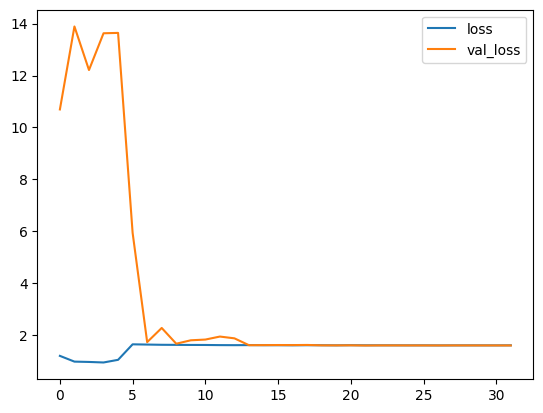

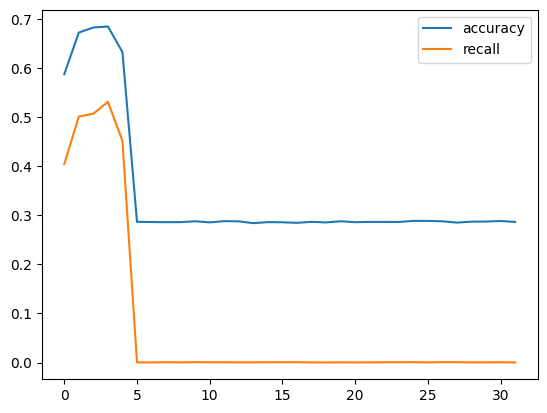

In [13]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy','recall']].plot()

In [14]:
loss, accuracy,recall = model.evaluate(test_generator)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2663 - loss: 1.6192 - recall: 0.0000e+00
Loss: 1.6299785375595093
Accuracy: 0.2532327473163605
